<a href="https://colab.research.google.com/github/Idan-Alter/OU-22961-Deep-Learning/blob/main/22961_4_4_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn

In [ ]:
!nvidia-smi 

Mon Mar 14 11:12:08 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!lscpu

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              2
On-line CPU(s) list: 0,1
Thread(s) per core:  2
Core(s) per socket:  1
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               63
Model name:          Intel(R) Xeon(R) CPU @ 2.30GHz
Stepping:            0
CPU MHz:             2299.998
BogoMIPS:            4599.99
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            256K
L3 cache:            46080K
NUMA node0 CPU(s):   0,1
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm invpcid_single ssbd ibrs 

In [ ]:
torch.cuda.is_available()

True

In [ ]:
if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  device = torch.device('cpu')
print(device)

cuda:0


In [ ]:
A = torch.empty(1)
print(A.device)
A = A.to(device)
print(A.device)

cpu
cuda:0


In [ ]:
A = torch.zeros(1, device=device)
B = torch.ones(1, device=device)
C = A+B
print(C.device)

cuda:0


In [ ]:
A = torch.zeros(1, device=device)
B = torch.ones(1, device='cpu')
C = A+B


RuntimeError: ignored

In [ ]:
import torchvision
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm
trans = torchvision.transforms.Compose(
    [torchvision.transforms.PILToTensor(),
     torchvision.transforms.ConvertImageDtype(torch.float)])

train_data = torchvision.datasets.FashionMNIST(
    root="/22961", train=True, download=True,
    transform=trans)

test_data = torchvision.datasets.FashionMNIST(
    root="/22961", train=False, download=True,
    transform=trans)

train_dataloader = DataLoader(train_data, batch_size=512,
                              num_workers=1,shuffle=True,pin_memory=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting /22961/FashionMNIST/raw/train-images-idx3-ubyte.gz to /22961/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting /22961/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /22961/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting /22961/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /22961/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting /22961/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /22961/FashionMNIST/raw



In [ ]:
# model = nn.Sequential(nn.Flatten(),
#           nn.Linear(784,4096),nn.ReLU(),
#           nn.Linear(4096,2048),nn.ReLU(),
#           nn.Linear(2048,1024),nn.ReLU(),
#           nn.Linear(1024,512),nn.ReLU(),
#           nn.Linear(512,256),nn.ReLU(),
#           nn.Linear(256,128),nn.ReLU(),
#           nn.Linear(128,10),
#           nn.LogSoftmax(dim=1)  #log(y)
#           ).to(device)

model   = nn.Sequential(nn.Flatten(), nn.Linear(784,10), nn.LogSoftmax(dim=1)).to(device)
CE_loss = nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [ ]:
def iterate_batch(imgs, labels):
  imgs   = imgs.to(device)
  labels = labels.to(device)
  
  optimizer.zero_grad()
  y_model = model(imgs)
  loss    = CE_loss(y_model, labels)
  loss.backward()
  optimizer.step()
  predicted_labels = y_model.argmax(dim=1)
  acc = (predicted_labels == labels).sum()/len(labels)
  return loss, acc

In [ ]:
from tqdm import tqdm
batches = len(train_dataloader)
batch_loss = torch.empty(batches, device=device)
batch_acc  = torch.empty(batches,device=device)
for idx, (imgs, labels) in tqdm(enumerate(train_dataloader)):
  batch_loss[idx], batch_acc[idx] = iterate_batch(imgs, labels)

118it [00:16,  7.05it/s]


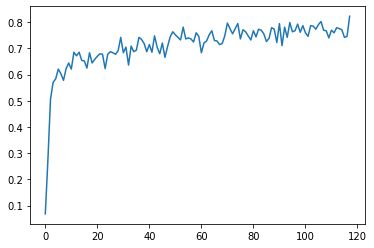

In [ ]:
plt.plot(batch_acc.cpu().detach());

In [ ]:
batch_acc.device

device(type='cuda', index=0)